# RSJ model: CPR of $I(\phi)=[\sin(\phi)+\eta\sin(2\phi)]+A(\sin(\phi+C)+\eta\sin[2(\phi+C)])$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import rc

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False


from scipy.integrate import odeint
from scipy.optimize import fmin
from scipy.io import savemat

In [5]:
%matplotlib inline

In [6]:
%load_ext Cython

In [7]:
%%cython
cimport numpy as np
from libc.math cimport sin,pi
import numpy as np

h=6.62607004e-34
hbar=h/2/pi
Qe=1.602176634e-19
Ic=2e-6
Rn=13
cdef double CPR(double G, double A, double eta, double C):
    '''
        Current-phase relationship for the junction
    '''
    return sin(G)+eta*sin(2*G)+A*sin(G+C*pi)+A*eta*sin(2*G+2*C*pi)
    
cpdef double dGdt(G,double t,double I,double A, double eta,double C):
    '''
        Define y = [gamma]
        dy_dt =  - f(gamma) + i(t)) 
    '''
    der = 2*Qe*Rn*(I-Ic*CPR(G,A,eta,C))/hbar
    return der 


### Plot CPR

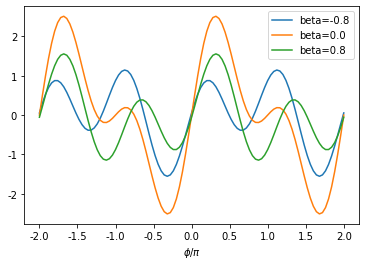

In [14]:
eta=0.7
A=0.7
def CPR2(G, A, eta, C):
    return np.sin(G)+eta*np.sin(2*G)+A*np.sin(G+C)+A*eta*np.sin(2*G+2*C)
phi=np.linspace(-2,2,101)*np.pi

beta=np.pi*np.linspace(-0.8,0.8,3)

Is=np.empty([len(phi),len(beta)])
plt.figure()
for j in range(0,len(beta)):
    for i in range(0,len(phi)):
        Is[i,j]=CPR2(phi[i],A,eta,beta[j])
    plt.plot(phi/np.pi,Is[:,j],label="beta="+str(np.round(beta[j]/np.pi,3)))
plt.xlabel('$\phi/\pi$')
plt.legend(loc=1)


In [9]:
from IPython import display

In [15]:
f0=2*Qe*Ic*Rn/h
print(f0/1e9,"GHz")
C=np.arange(-1,1.01,0.01)
eta_array=np.array([0.9])#np.linspace(0.5,0.9,5)
A_array=np.array([0.6])#np.linspace(0.5,0.9,5)
IDC_step=0.01
IDC_Sweep=np.array([-4,4,IDC_step])*Ic
IDC_array=np.arange(IDC_Sweep[0],IDC_Sweep[1],IDC_Sweep[2])
V=np.empty([len(C),len(IDC_array)])
DVDI=np.empty([len(C),len(IDC_array)])

print(IDC_array.shape)
print(C.shape)

12.573544267576139 GHz
(800,)
(201,)


## Model,  Dynamic Plot & Save .mat

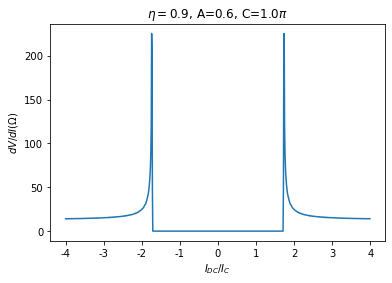

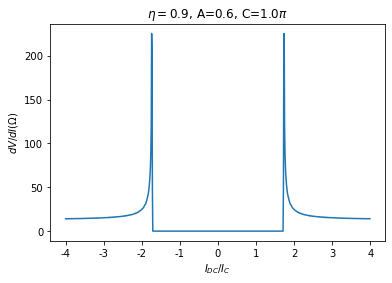

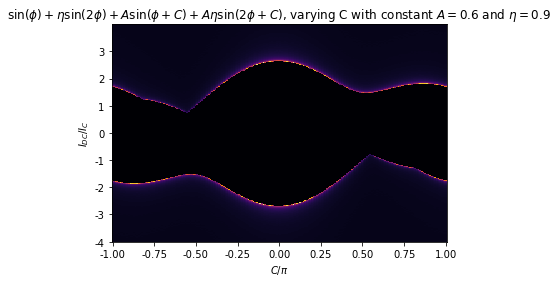

In [16]:
plt.ion()
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

for A in A_array:
    for eta in eta_array:
        for x in range(0,len(C)):
            display.clear_output(wait=True)

            for j in range(0,len(IDC_array)):
                t=np.arange(0,500.01,0.01)/f0
                G_array= odeint(dGdt,0,t,args=(IDC_array[j],A,eta,C[x]))
                #V[x,j]=np.squeeze(G_array[-1]-G_array[-1501])*f0*(hbar/2/Qe)/15 # Doesn't work for some cases.
                V[x,j]=np.mean(np.gradient(G_array[:-3001,0]))/(0.01/f0)*(hbar/2/Qe)
            DVDI[x,:]=np.gradient(V[x,:],IDC_step*Ic)
            #print("C="+str(C[x]/np.pi)+"$\pi$",end="\r")
            ax.clear()
            ax.plot(IDC_array/Ic,DVDI[x,:])
            plt.title("$\eta=$"+str(eta)+", A="+str(A)+", C="+str(np.round(C[x],3))+"$\pi$")
            plt.xlabel("$I_{DC}/I_C$")
            plt.ylabel("$dV/dI(\Omega)$")
            display.display(plt.gcf())

        plt.figure()
        plt.pcolor(C,IDC_array/Ic,np.transpose(DVDI),cmap='inferno',shading='auto')
        plt.xlabel("$C/\pi$")
        plt.ylabel("$I_{DC}/I_C$")
        plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A)+" and $\eta=$"+str(eta))
        plt.savefig("./two_channels_A"+str(A)+"_eta_"+str(eta)+"_step_0p005_201ptC.pdf")

        savemat("./two_channels_A"+str(A)+"_eta_"+str(eta)+"_step_0p005_201ptC.mat",mdict={'IDC':IDC_array,'C':C,'V':V,'DVDI':DVDI,'eta':eta,'A':A})


### load data and plot

In [17]:
from scipy.io import loadmat

In [18]:
data=loadmat("./two_channels_A0.6_eta_0.9_step_0p005_201ptC.mat")

In [19]:
list(data.keys())

['__header__',
 '__version__',
 '__globals__',
 'IDC',
 'C',
 'V',
 'DVDI',
 'eta',
 'A']

In [22]:
data=loadmat("./two_channels_A0.8_eta_0.9_step_0p005_201ptC.mat")
IDC=np.squeeze(data['IDC'])
C=np.squeeze(data['C'])
V=data['V']
DVDI=data['DVDI']
eta=data['eta']
A=data['A']
Ic=2e-6
Rn=13

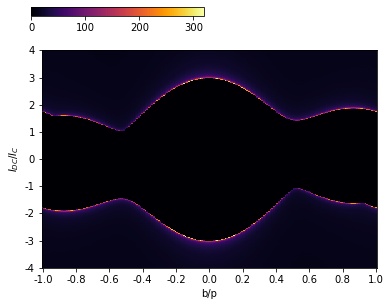

In [26]:
fig=plt.figure()
ax=plt.pcolor(C,IDC/Ic,np.transpose(DVDI),cmap='inferno',vmin=0,linewidth=0,rasterized=True,shading='auto')
plt.xticks(np.arange(-1,1.2,0.2))
plt.yticks(np.arange(-4,5,1))
plt.xlabel("b/p")
plt.ylabel("$I_{DC}/I_C$")
cbaxes = fig.add_axes([0.1, 1, 0.4, 0.03]) 


plt.colorbar(ax, orientation="horizontal",cax=cbaxes)
#cb=fig.colorbar(ax, orientation="horizontal",cax=cbaxes)
#plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A)+" and $\eta=$"+str(eta))
plt.savefig("map_dense_eta_0p9_A_0p6.pdf",bbox_inches='tight')


# Save it into a .csv file

In [ ]:
#np.savetxt("./eta0p7_A0p7/csv/IDC.csv", IDC, delimiter=",")
#np.savetxt("./eta0p7_A0p7/csv/C.csv", C, delimiter=",")
#np.savetxt("./eta0p7_A0p7/csv/V.csv", V, delimiter=",")
#np.savetxt("./eta0p7_A0p7/csv/DVDI.csv", DVDI, delimiter=",")
